## Chapter 7: VQE_pyquil

In [10]:
# Variational-Quantum-Eigensolver
import numpy as np
from scipy.optimize import minimize
from pyquil.api import QVMConnection
import pyquil.api as api
from pyquil.gates import *
from pyquil import Program, get_qc
from grove.pyvqe.vqe import VQE

# Create connection with QVM

qvm = api.QVMConnection()
qc = get_qc('2q-qvm')

# Define matrix
from pyquil.paulis import sZ
H = sZ(0)

In [11]:
# Define ansatz
from pyquil.gates import RY
def ansatz(params):
    return Program(RY(params[0], 0))


In [12]:
# Function calculating expectation value
def expectation(params):
    
    # Define number of measurments
    samples = 10000
    
    # Define program
    prog = ansatz(params)
    
    # Measure
    ro = prog.declare('ro', 'BIT', 1) # Classical registry storing the results
    prog.measure(0, ro[0])
    
    # Compile and execute
    prog.wrap_in_numshots_loop(samples)
    prog_exec = qc.compile(prog)
    ret = qc.run(prog_exec)
    
    # Calculate expectation
    freq_is_0 = [trial[0] for trial in ret].count(0) / samples
    freq_is_1 = [trial[0] for trial in ret].count(1) / samples
    
    return freq_is_0 - freq_is_1

# Test of expectation value function  
test = expectation([0.0]) 
print(test)


1.0


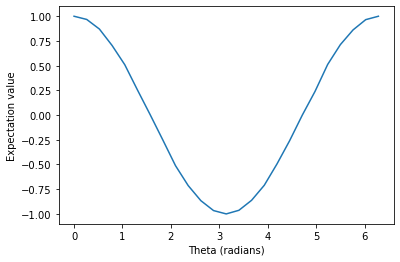

The minimum bound on the lowest eigenvalue of M is E0=-1.0,

The parameter that corresponds to this energy is theta=3.14 Rads


In [13]:
# Draw expectation alue against parameter value
params_range = np.linspace(0.0, 2 * np.pi, 25)
data = [expectation([params]) for params in params_range]

import matplotlib.pyplot as plt
plt.xlabel('Theta (radians)')
plt.ylabel('Expectation value')
plt.plot(params_range, data)
plt.show()

# Determine the lowest bound from varying theta
print('='*100)
print('The minimum bound on the lowest eigenvalue of M is E0={},\n'.format(min(data)))
print('The parameter that corresponds to this energy is theta={:0.2f} Rads'.format(params_range[np.argmin(data)]))
print('='*100)

In [14]:
# Eigenvalue Optimization
initial_params = [0.0]
minimum = minimize(expectation, initial_params, method='Nelder-Mead', 
                   options={'initial_simplex': np.array([[0.0], [0.05]]), 'xatol': 1.0e-2})
print(minimum)

 final_simplex: (array([[3.1375 ],
       [3.14375]]), array([-1., -1.]))
           fun: -1.0
       message: 'Optimization terminated successfully.'
          nfev: 28
           nit: 14
        status: 0
       success: True
             x: array([3.1375])


In [15]:
pauli_channel = [0.1, 0.1, 0.1] #10% chance of each gate at each timestep
noisy_qvm = api.QVMConnection(gate_noise=pauli_channel)

In [17]:
#Verify Simulator is indeed noisy

p = Program(X(0), MEASURE(0, 1))
noisy_qvm.run(p, [1, 1], 10)

[[1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [0, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [0, 0],
 [1, 1]]

### VQE for Molecular Systems

In [18]:
# Molecular Systems Solutions
from pyquil.paulis import sY
initial_angle = [0.0]
#Hamiltonian is sigma Y
hamiltonian = sY(0)
vqe_inst = VQE(minimizer=minimize,
               minimizer_kwargs={'method': 'nelder-mead'})
#ansatz is rotation by X
def small_ansatz(params):
    return Program(RX(params[0], 0))
#looping from 0 to 2 pi
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(small_ansatz([angle]), hamiltonian, 10000, qvm)
        for angle in angle_range]

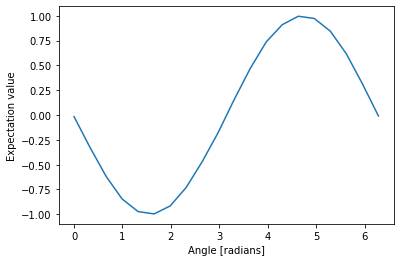

In [19]:
plt.xlabel('Angle [radians]')
plt.ylabel('Expectation value')
plt.plot(angle_range, data)
plt.show()